In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import xgboost as xgb

import itertools
import math

%matplotlib inline

# pd.set_option("display.max_rows", 10)

np.random.seed(2)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.wrappers.scikit_learn import KerasRegressor


In [27]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train.shape

(1460, 81)

In [28]:
train.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [29]:
train['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.882876
Kurtosis: 6.536282


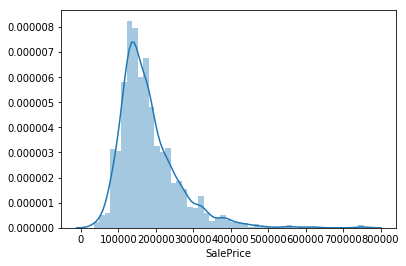

In [33]:
sns.distplot(train['SalePrice']);
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


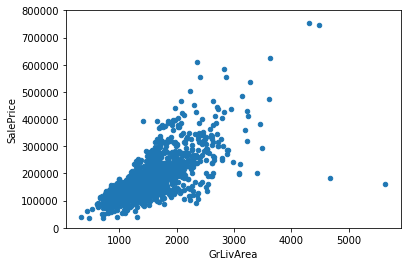

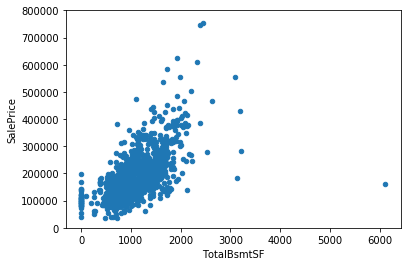

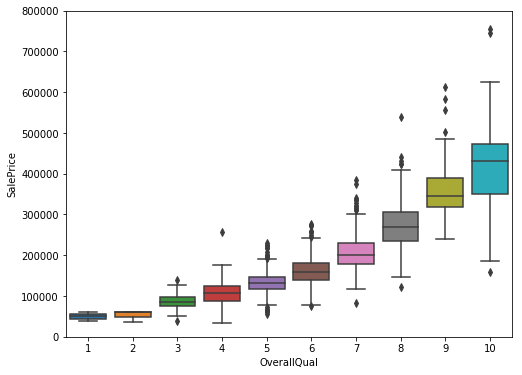

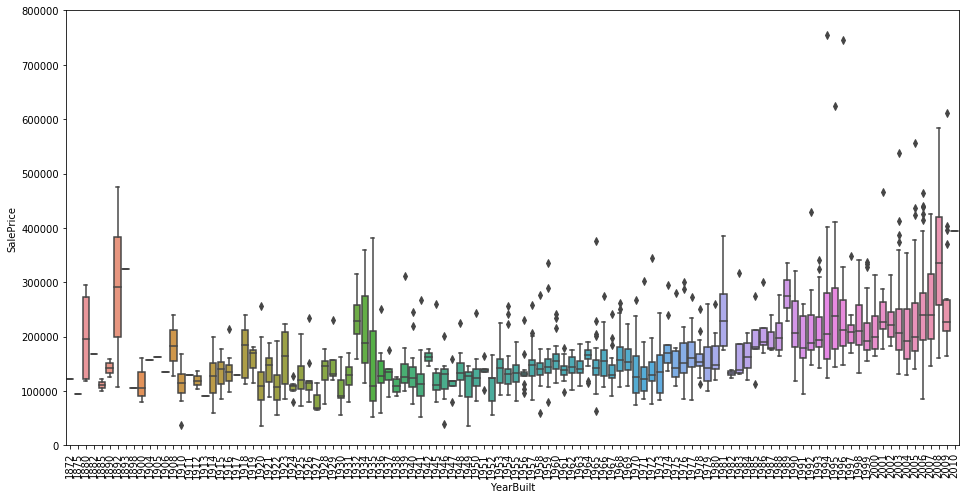

In [38]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);


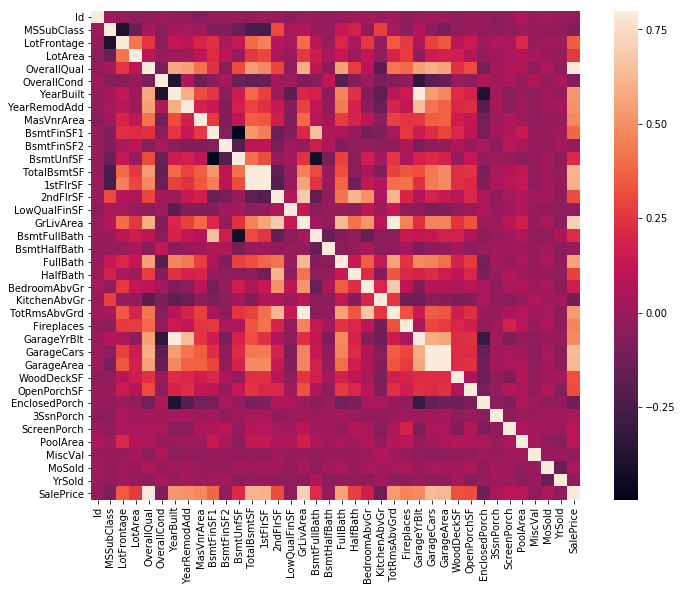

In [39]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


In [10]:
# selecting columns

set1_cols = ['Id', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF']
set2_cols = ['MSZoning', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleCondition', 'SaleType']
set3_cols = ['BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr']
set4_cols = ['GrLivArea', 'LotArea', 'GarageArea', 'OpenPorchSF']
target_col = ['SalePrice']

train_set_1 = train[set1_cols]
train_set_2 = train[set2_cols]
train_set_3 = train[set3_cols]
train_set_4 = train[set4_cols]
train_target = train[target_col]

test_set_1 = test[set1_cols]
test_set_2 = test[set2_cols]
test_set_3 = test[set3_cols]
test_set_4 = test[set4_cols]



In [11]:
# Fixing data
train_set_2.loc[:,'Electrical'] = train_set_2.loc[:,'Electrical'].fillna('Unk')

test_set_2.loc[:,('Electrical')] = test_set_2.loc[:,('Electrical')].fillna('Unk')
test_set_2.loc[:,('Utilities')] = test_set_2.loc[:,('Utilities')].fillna('Unk')
test_set_2.loc[:,('MSZoning')] = test_set_2.loc[:,('MSZoning')].fillna('Unk')
test_set_2.loc[:,('Exterior1st')] = test_set_2.loc[:,('Exterior1st')].fillna('Unk')
test_set_2.loc[:,('Exterior2nd')] = test_set_2.loc[:,('Exterior2nd')].fillna('Unk')
test_set_2.loc[:,('KitchenQual')] = test_set_2.loc[:,('KitchenQual')].fillna('Unk')
test_set_2.loc[:,('SaleType')] = test_set_2.loc[:,('SaleType')].fillna('Unk')
test_set_3.loc[:,('BsmtFullBath')] = test_set_3.loc[:,('BsmtFullBath')].fillna(0)
test_set_4.loc[:,('GarageArea')] = test_set_4.loc[:,('GarageArea')].fillna(0)


/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
# generating labels for categorical features
labels = np.array([])
# train
for c_name in train_set_2.columns.values:
    labels = np.append(labels, train_set_2[c_name].unique())
# test
for c_name in test_set_2.columns.values:
    labels = np.append(labels, test_set_2[c_name].unique())
# fit
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels.tolist())

# transform
for c_name in train_set_2.columns.values:
    train_set_2[c_name] = label_encoder.transform(train_set_2[c_name])

for c_name in test_set_2.columns.values:
    test_set_2[c_name] = label_encoder.transform(test_set_2[c_name])

# generate labeled sets
train_labeled = pd.concat([train_set_1, train_set_2, train_set_3, train_set_4], axis=1)
test_labeled = pd.concat([test_set_1, test_set_2, test_set_3, test_set_4], axis=1)



/home/daniele/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/daniele/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# scaling features

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_labeled)
X_train = scaler.transform(train_labeled)
y_train = (train_target/1e06).values

test_scaled = scaler.transform(test_labeled)


/home/daniele/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [14]:
def nn_model(train):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, input_dim = train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, activation='relu'))
    NN_model.add(Dropout(.5))
    NN_model.add(Dense(256, activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, activation='linear') )

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
    return NN_model

model = nn_model(X_train)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4480      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 103,553
Trainable params: 103,553
Non-trainable params: 0
_________________________________________________________________
Train on 1168 samples, validate on 292 samples
Epoch 1/200
 - 0s - loss: 0.0770 - mean_absolute_error: 0.0770 - val_loss: 0.0616 - val_m

Epoch 63/200
 - 0s - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 64/200
 - 0s - loss: 0.0154 - mean_absolute_error: 0.0154 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 65/200
 - 0s - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 66/200
 - 0s - loss: 0.0157 - mean_absolute_error: 0.0157 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 67/200
 - 0s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 68/200
 - 0s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 69/200
 - 0s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 70/200
 - 0s - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 71/200
 - 0s - loss: 0.0149 - mean_absolute_error: 0.0149 

Epoch 133/200
 - 0s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 134/200
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 135/200
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 136/200
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 137/200
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 138/200
 - 0s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 139/200
 - 0s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 140/200
 - 0s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 141/200
 - 0s - loss: 0.0117 - mean_absolute_error

In [15]:
predict = model.predict(X_train)
print('RMSE on train set = %.6f' % math.sqrt(mean_squared_error(y_train* 1e06, predict* 1e06)))

# top: RMSE = 30155.097325
#  - 0s - loss: 17869.9908 - mean_absolute_error: 17869.9908 - val_loss: 22195.5058 - val_mean_absolute_error: 22195.5058


RMSE on train set = 33074.713645


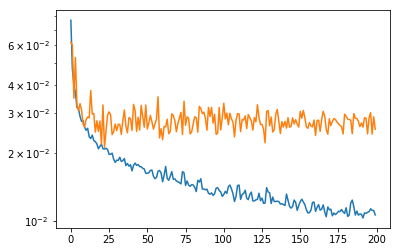

In [16]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

In [17]:
labels = np.array([])

test_predict = model.predict(test_scaled) * 1e06
test_predict = pd.DataFrame(test_predict)


In [18]:

test_predict['Id'] = test.values[:,0]

test_predict.columns = ['SalePrice', 'Id']

test_predict.to_csv('submission.csv', index=False)
test_predict[0:10]

,SalePrice,Id
0,123973.179688,1461
1,164414.937500,1462
2,162384.750000,1463
3,168588.484375,1464
4,172018.671875,1465
5,168475.953125,1466
6,153422.968750,1467
7,162083.062500,1468
8,179224.468750,1469
9,118217.093750,1470


In [19]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [20]:
def train(dtrain, dtest, depth, rounds):
    # Train xgboost
    param = {'max_depth' : depth, 'silent': 1, 'eta' : 0.5, 'objective' : 'reg:linear', 'seed' : 42}
    num_round = rounds
    bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])
    return bst

def check(bst):
    # make prediction
    train_pred = bst.predict(dtrain) * 1e06
    rmse_train = math.sqrt(mean_squared_error(y_tr[:,0] * 1e06, train_pred))
    #print('RMSE on train set = %.6f' % rmse_train)
    test_pred = bst.predict(dtest) * 1e06
    rmse_test = math.sqrt(mean_squared_error(y_ts[:,0] * 1e06, test_pred))
    #print('RMSE on test set = %.6f' % rmse_test)
    return rmse_train, rmse_test

result = []
for depth in range(2, 5):
    for rounds in range(10, 60, 2):
        dtrain = xgb.DMatrix(X_tr, y_tr)
        dtest = xgb.DMatrix(X_ts, y_ts)
        bst = train(dtrain, dtest, depth, rounds)
        rmse_train, rmse_test = check(bst)
        result.append([depth, rounds, rmse_train, rmse_test])



[0]	test-rmse:0.1741	train-rmse:0.169328
[1]	test-rmse:0.096749	train-rmse:0.092422
[2]	test-rmse:0.062191	train-rmse:0.056518
[3]	test-rmse:0.047663	train-rmse:0.041643
[4]	test-rmse:0.042315	train-rmse:0.035189
[5]	test-rmse:0.040096	train-rmse:0.032498
[6]	test-rmse:0.0385	train-rmse:0.030779
[7]	test-rmse:0.037245	train-rmse:0.029758
[8]	test-rmse:0.035968	train-rmse:0.02876
[9]	test-rmse:0.034559	train-rmse:0.027867
[0]	test-rmse:0.1741	train-rmse:0.169328
[1]	test-rmse:0.096749	train-rmse:0.092422
[2]	test-rmse:0.062191	train-rmse:0.056518
[3]	test-rmse:0.047663	train-rmse:0.041643
[4]	test-rmse:0.042315	train-rmse:0.035189
[5]	test-rmse:0.040096	train-rmse:0.032498
[6]	test-rmse:0.0385	train-rmse:0.030779
[7]	test-rmse:0.037245	train-rmse:0.029758
[8]	test-rmse:0.035968	train-rmse:0.02876
[9]	test-rmse:0.034559	train-rmse:0.027867
[10]	test-rmse:0.034105	train-rmse:0.0272
[11]	test-rmse:0.033658	train-rmse:0.026378
[0]	test-rmse:0.1741	train-rmse:0.169328
[1]	test-rmse:0.096749	

[1]	test-rmse:0.096749	train-rmse:0.092422
[2]	test-rmse:0.062191	train-rmse:0.056518
[3]	test-rmse:0.047663	train-rmse:0.041643
[4]	test-rmse:0.042315	train-rmse:0.035189
[5]	test-rmse:0.040096	train-rmse:0.032498
[6]	test-rmse:0.0385	train-rmse:0.030779
[7]	test-rmse:0.037245	train-rmse:0.029758
[8]	test-rmse:0.035968	train-rmse:0.02876
[9]	test-rmse:0.034559	train-rmse:0.027867
[10]	test-rmse:0.034105	train-rmse:0.0272
[11]	test-rmse:0.033658	train-rmse:0.026378
[12]	test-rmse:0.033171	train-rmse:0.025779
[13]	test-rmse:0.032668	train-rmse:0.025384
[14]	test-rmse:0.032241	train-rmse:0.025005
[15]	test-rmse:0.032555	train-rmse:0.024703
[16]	test-rmse:0.032246	train-rmse:0.024086
[17]	test-rmse:0.031619	train-rmse:0.023745
[18]	test-rmse:0.031424	train-rmse:0.023496
[19]	test-rmse:0.030957	train-rmse:0.023285
[20]	test-rmse:0.030825	train-rmse:0.022995
[21]	test-rmse:0.030646	train-rmse:0.022772
[22]	test-rmse:0.030636	train-rmse:0.022634
[23]	test-rmse:0.030485	train-rmse:0.022353
[2

[20]	test-rmse:0.030825	train-rmse:0.022995
[21]	test-rmse:0.030646	train-rmse:0.022772
[22]	test-rmse:0.030636	train-rmse:0.022634
[23]	test-rmse:0.030485	train-rmse:0.022353
[24]	test-rmse:0.030462	train-rmse:0.022204
[25]	test-rmse:0.030344	train-rmse:0.022009
[26]	test-rmse:0.030313	train-rmse:0.021819
[27]	test-rmse:0.030227	train-rmse:0.021687
[28]	test-rmse:0.030143	train-rmse:0.021569
[29]	test-rmse:0.030718	train-rmse:0.021324
[30]	test-rmse:0.031088	train-rmse:0.02107
[31]	test-rmse:0.03106	train-rmse:0.020874
[32]	test-rmse:0.030878	train-rmse:0.020772
[33]	test-rmse:0.031263	train-rmse:0.020554
[34]	test-rmse:0.031177	train-rmse:0.02031
[35]	test-rmse:0.031021	train-rmse:0.020152
[36]	test-rmse:0.030928	train-rmse:0.020002
[37]	test-rmse:0.030915	train-rmse:0.019858
[38]	test-rmse:0.030839	train-rmse:0.019762
[39]	test-rmse:0.030488	train-rmse:0.019559
[0]	test-rmse:0.1741	train-rmse:0.169328
[1]	test-rmse:0.096749	train-rmse:0.092422
[2]	test-rmse:0.062191	train-rmse:0.056

[37]	test-rmse:0.030915	train-rmse:0.019858
[38]	test-rmse:0.030839	train-rmse:0.019762
[39]	test-rmse:0.030488	train-rmse:0.019559
[40]	test-rmse:0.03038	train-rmse:0.019337
[41]	test-rmse:0.030129	train-rmse:0.019251
[42]	test-rmse:0.030156	train-rmse:0.019126
[43]	test-rmse:0.030184	train-rmse:0.019038
[44]	test-rmse:0.030184	train-rmse:0.018966
[45]	test-rmse:0.030021	train-rmse:0.018844
[46]	test-rmse:0.030263	train-rmse:0.018689
[47]	test-rmse:0.029953	train-rmse:0.018511
[0]	test-rmse:0.1741	train-rmse:0.169328
[1]	test-rmse:0.096749	train-rmse:0.092422
[2]	test-rmse:0.062191	train-rmse:0.056518
[3]	test-rmse:0.047663	train-rmse:0.041643
[4]	test-rmse:0.042315	train-rmse:0.035189
[5]	test-rmse:0.040096	train-rmse:0.032498
[6]	test-rmse:0.0385	train-rmse:0.030779
[7]	test-rmse:0.037245	train-rmse:0.029758
[8]	test-rmse:0.035968	train-rmse:0.02876
[9]	test-rmse:0.034559	train-rmse:0.027867
[10]	test-rmse:0.034105	train-rmse:0.0272
[11]	test-rmse:0.033658	train-rmse:0.026378
[12]	t

[22]	test-rmse:0.030636	train-rmse:0.022634
[23]	test-rmse:0.030485	train-rmse:0.022353
[24]	test-rmse:0.030462	train-rmse:0.022204
[25]	test-rmse:0.030344	train-rmse:0.022009
[26]	test-rmse:0.030313	train-rmse:0.021819
[27]	test-rmse:0.030227	train-rmse:0.021687
[28]	test-rmse:0.030143	train-rmse:0.021569
[29]	test-rmse:0.030718	train-rmse:0.021324
[30]	test-rmse:0.031088	train-rmse:0.02107
[31]	test-rmse:0.03106	train-rmse:0.020874
[32]	test-rmse:0.030878	train-rmse:0.020772
[33]	test-rmse:0.031263	train-rmse:0.020554
[34]	test-rmse:0.031177	train-rmse:0.02031
[35]	test-rmse:0.031021	train-rmse:0.020152
[36]	test-rmse:0.030928	train-rmse:0.020002
[37]	test-rmse:0.030915	train-rmse:0.019858
[38]	test-rmse:0.030839	train-rmse:0.019762
[39]	test-rmse:0.030488	train-rmse:0.019559
[40]	test-rmse:0.03038	train-rmse:0.019337
[41]	test-rmse:0.030129	train-rmse:0.019251
[42]	test-rmse:0.030156	train-rmse:0.019126
[43]	test-rmse:0.030184	train-rmse:0.019038
[44]	test-rmse:0.030184	train-rmse:0

[7]	test-rmse:0.033249	train-rmse:0.023494
[8]	test-rmse:0.033021	train-rmse:0.022655
[9]	test-rmse:0.0324	train-rmse:0.021863
[10]	test-rmse:0.031922	train-rmse:0.021271
[11]	test-rmse:0.031838	train-rmse:0.020983
[12]	test-rmse:0.030937	train-rmse:0.020253
[13]	test-rmse:0.030825	train-rmse:0.019751
[14]	test-rmse:0.030765	train-rmse:0.019475
[15]	test-rmse:0.031526	train-rmse:0.018942
[16]	test-rmse:0.031443	train-rmse:0.018681
[17]	test-rmse:0.031139	train-rmse:0.018321
[18]	test-rmse:0.03111	train-rmse:0.017997
[19]	test-rmse:0.031172	train-rmse:0.017692
[20]	test-rmse:0.031267	train-rmse:0.017464
[21]	test-rmse:0.031159	train-rmse:0.017265
[0]	test-rmse:0.172018	train-rmse:0.168272
[1]	test-rmse:0.092722	train-rmse:0.089885
[2]	test-rmse:0.056942	train-rmse:0.052495
[3]	test-rmse:0.041762	train-rmse:0.03567
[4]	test-rmse:0.036241	train-rmse:0.028755
[5]	test-rmse:0.034304	train-rmse:0.025956
[6]	test-rmse:0.033709	train-rmse:0.024353
[7]	test-rmse:0.033249	train-rmse:0.023494
[8]

[0]	test-rmse:0.172018	train-rmse:0.168272
[1]	test-rmse:0.092722	train-rmse:0.089885
[2]	test-rmse:0.056942	train-rmse:0.052495
[3]	test-rmse:0.041762	train-rmse:0.03567
[4]	test-rmse:0.036241	train-rmse:0.028755
[5]	test-rmse:0.034304	train-rmse:0.025956
[6]	test-rmse:0.033709	train-rmse:0.024353
[7]	test-rmse:0.033249	train-rmse:0.023494
[8]	test-rmse:0.033021	train-rmse:0.022655
[9]	test-rmse:0.0324	train-rmse:0.021863
[10]	test-rmse:0.031922	train-rmse:0.021271
[11]	test-rmse:0.031838	train-rmse:0.020983
[12]	test-rmse:0.030937	train-rmse:0.020253
[13]	test-rmse:0.030825	train-rmse:0.019751
[14]	test-rmse:0.030765	train-rmse:0.019475
[15]	test-rmse:0.031526	train-rmse:0.018942
[16]	test-rmse:0.031443	train-rmse:0.018681
[17]	test-rmse:0.031139	train-rmse:0.018321
[18]	test-rmse:0.03111	train-rmse:0.017997
[19]	test-rmse:0.031172	train-rmse:0.017692
[20]	test-rmse:0.031267	train-rmse:0.017464
[21]	test-rmse:0.031159	train-rmse:0.017265
[22]	test-rmse:0.030998	train-rmse:0.017008
[2

[32]	test-rmse:0.031012	train-rmse:0.015059
[33]	test-rmse:0.030966	train-rmse:0.014815
[34]	test-rmse:0.030969	train-rmse:0.014713
[35]	test-rmse:0.030924	train-rmse:0.014518
[36]	test-rmse:0.030895	train-rmse:0.01441
[37]	test-rmse:0.030728	train-rmse:0.014163
[38]	test-rmse:0.030639	train-rmse:0.013965
[39]	test-rmse:0.030616	train-rmse:0.013826
[40]	test-rmse:0.030668	train-rmse:0.013626
[41]	test-rmse:0.030689	train-rmse:0.013476
[42]	test-rmse:0.030926	train-rmse:0.013371
[43]	test-rmse:0.030922	train-rmse:0.0133
[0]	test-rmse:0.172018	train-rmse:0.168272
[1]	test-rmse:0.092722	train-rmse:0.089885
[2]	test-rmse:0.056942	train-rmse:0.052495
[3]	test-rmse:0.041762	train-rmse:0.03567
[4]	test-rmse:0.036241	train-rmse:0.028755
[5]	test-rmse:0.034304	train-rmse:0.025956
[6]	test-rmse:0.033709	train-rmse:0.024353
[7]	test-rmse:0.033249	train-rmse:0.023494
[8]	test-rmse:0.033021	train-rmse:0.022655
[9]	test-rmse:0.0324	train-rmse:0.021863
[10]	test-rmse:0.031922	train-rmse:0.021271
[11]

[32]	test-rmse:0.031012	train-rmse:0.015059
[33]	test-rmse:0.030966	train-rmse:0.014815
[34]	test-rmse:0.030969	train-rmse:0.014713
[35]	test-rmse:0.030924	train-rmse:0.014518
[36]	test-rmse:0.030895	train-rmse:0.01441
[37]	test-rmse:0.030728	train-rmse:0.014163
[38]	test-rmse:0.030639	train-rmse:0.013965
[39]	test-rmse:0.030616	train-rmse:0.013826
[40]	test-rmse:0.030668	train-rmse:0.013626
[41]	test-rmse:0.030689	train-rmse:0.013476
[42]	test-rmse:0.030926	train-rmse:0.013371
[43]	test-rmse:0.030922	train-rmse:0.0133
[44]	test-rmse:0.03084	train-rmse:0.01316
[45]	test-rmse:0.030853	train-rmse:0.013024
[46]	test-rmse:0.03081	train-rmse:0.012858
[47]	test-rmse:0.030781	train-rmse:0.012704
[48]	test-rmse:0.030679	train-rmse:0.012568
[49]	test-rmse:0.030616	train-rmse:0.012478
[50]	test-rmse:0.030572	train-rmse:0.012416
[51]	test-rmse:0.030448	train-rmse:0.012242
[0]	test-rmse:0.172018	train-rmse:0.168272
[1]	test-rmse:0.092722	train-rmse:0.089885
[2]	test-rmse:0.056942	train-rmse:0.0524

[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:0.091963	train-rmse:0.088695
[2]	test-rmse:0.05559	train-rmse:0.049971
[3]	test-rmse:0.039836	train-rmse:0.032687
[4]	test-rmse:0.033173	train-rmse:0.024804
[5]	test-rmse:0.031476	train-rmse:0.021726
[6]	test-rmse:0.030191	train-rmse:0.020254
[7]	test-rmse:0.029753	train-rmse:0.019431
[8]	test-rmse:0.029433	train-rmse:0.018607
[9]	test-rmse:0.029289	train-rmse:0.018051
[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:0.091963	train-rmse:0.088695
[2]	test-rmse:0.05559	train-rmse:0.049971
[3]	test-rmse:0.039836	train-rmse:0.032687
[4]	test-rmse:0.033173	train-rmse:0.024804
[5]	test-rmse:0.031476	train-rmse:0.021726
[6]	test-rmse:0.030191	train-rmse:0.020254
[7]	test-rmse:0.029753	train-rmse:0.019431
[8]	test-rmse:0.029433	train-rmse:0.018607
[9]	test-rmse:0.029289	train-rmse:0.018051
[10]	test-rmse:0.029369	train-rmse:0.017513
[11]	test-rmse:0.029356	train-rmse:0.017063
[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:

[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:0.091963	train-rmse:0.088695
[2]	test-rmse:0.05559	train-rmse:0.049971
[3]	test-rmse:0.039836	train-rmse:0.032687
[4]	test-rmse:0.033173	train-rmse:0.024804
[5]	test-rmse:0.031476	train-rmse:0.021726
[6]	test-rmse:0.030191	train-rmse:0.020254
[7]	test-rmse:0.029753	train-rmse:0.019431
[8]	test-rmse:0.029433	train-rmse:0.018607
[9]	test-rmse:0.029289	train-rmse:0.018051
[10]	test-rmse:0.029369	train-rmse:0.017513
[11]	test-rmse:0.029356	train-rmse:0.017063
[12]	test-rmse:0.028839	train-rmse:0.016377
[13]	test-rmse:0.029183	train-rmse:0.015974
[14]	test-rmse:0.029067	train-rmse:0.015561
[15]	test-rmse:0.028874	train-rmse:0.015258
[16]	test-rmse:0.028852	train-rmse:0.014965
[17]	test-rmse:0.028812	train-rmse:0.014576
[18]	test-rmse:0.028706	train-rmse:0.014115
[19]	test-rmse:0.028721	train-rmse:0.013613
[20]	test-rmse:0.028639	train-rmse:0.013357
[21]	test-rmse:0.028641	train-rmse:0.013212
[22]	test-rmse:0.02857	train-rmse:0.01291
[2

[19]	test-rmse:0.028721	train-rmse:0.013613
[20]	test-rmse:0.028639	train-rmse:0.013357
[21]	test-rmse:0.028641	train-rmse:0.013212
[22]	test-rmse:0.02857	train-rmse:0.01291
[23]	test-rmse:0.028439	train-rmse:0.012462
[24]	test-rmse:0.028391	train-rmse:0.012122
[25]	test-rmse:0.02837	train-rmse:0.0119
[26]	test-rmse:0.028409	train-rmse:0.011719
[27]	test-rmse:0.02839	train-rmse:0.01156
[28]	test-rmse:0.028374	train-rmse:0.01143
[29]	test-rmse:0.028323	train-rmse:0.011324
[30]	test-rmse:0.028424	train-rmse:0.011151
[31]	test-rmse:0.028442	train-rmse:0.011041
[32]	test-rmse:0.028457	train-rmse:0.010984
[33]	test-rmse:0.028488	train-rmse:0.010831
[34]	test-rmse:0.02839	train-rmse:0.010764
[35]	test-rmse:0.028393	train-rmse:0.01061
[36]	test-rmse:0.028469	train-rmse:0.010439
[37]	test-rmse:0.028452	train-rmse:0.010164
[38]	test-rmse:0.028484	train-rmse:0.010023
[39]	test-rmse:0.028539	train-rmse:0.009816
[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:0.091963	train-rmse:0.088695
[

[36]	test-rmse:0.028469	train-rmse:0.010439
[37]	test-rmse:0.028452	train-rmse:0.010164
[38]	test-rmse:0.028484	train-rmse:0.010023
[39]	test-rmse:0.028539	train-rmse:0.009816
[40]	test-rmse:0.028535	train-rmse:0.009537
[41]	test-rmse:0.028535	train-rmse:0.009475
[42]	test-rmse:0.028503	train-rmse:0.009418
[43]	test-rmse:0.028552	train-rmse:0.009197
[44]	test-rmse:0.02853	train-rmse:0.008967
[45]	test-rmse:0.028628	train-rmse:0.008804
[46]	test-rmse:0.028537	train-rmse:0.008739
[47]	test-rmse:0.028514	train-rmse:0.008657
[0]	test-rmse:0.171668	train-rmse:0.16794
[1]	test-rmse:0.091963	train-rmse:0.088695
[2]	test-rmse:0.05559	train-rmse:0.049971
[3]	test-rmse:0.039836	train-rmse:0.032687
[4]	test-rmse:0.033173	train-rmse:0.024804
[5]	test-rmse:0.031476	train-rmse:0.021726
[6]	test-rmse:0.030191	train-rmse:0.020254
[7]	test-rmse:0.029753	train-rmse:0.019431
[8]	test-rmse:0.029433	train-rmse:0.018607
[9]	test-rmse:0.029289	train-rmse:0.018051
[10]	test-rmse:0.029369	train-rmse:0.017513
[

[21]	test-rmse:0.028641	train-rmse:0.013212
[22]	test-rmse:0.02857	train-rmse:0.01291
[23]	test-rmse:0.028439	train-rmse:0.012462
[24]	test-rmse:0.028391	train-rmse:0.012122
[25]	test-rmse:0.02837	train-rmse:0.0119
[26]	test-rmse:0.028409	train-rmse:0.011719
[27]	test-rmse:0.02839	train-rmse:0.01156
[28]	test-rmse:0.028374	train-rmse:0.01143
[29]	test-rmse:0.028323	train-rmse:0.011324
[30]	test-rmse:0.028424	train-rmse:0.011151
[31]	test-rmse:0.028442	train-rmse:0.011041
[32]	test-rmse:0.028457	train-rmse:0.010984
[33]	test-rmse:0.028488	train-rmse:0.010831
[34]	test-rmse:0.02839	train-rmse:0.010764
[35]	test-rmse:0.028393	train-rmse:0.01061
[36]	test-rmse:0.028469	train-rmse:0.010439
[37]	test-rmse:0.028452	train-rmse:0.010164
[38]	test-rmse:0.028484	train-rmse:0.010023
[39]	test-rmse:0.028539	train-rmse:0.009816
[40]	test-rmse:0.028535	train-rmse:0.009537
[41]	test-rmse:0.028535	train-rmse:0.009475
[42]	test-rmse:0.028503	train-rmse:0.009418
[43]	test-rmse:0.028552	train-rmse:0.00919

In [21]:
# check results
result = pd.DataFrame(result, columns=['depth', 'rounds', 'rmse_train', 'rmse_test'])
result.describe()


,depth,rounds,rmse_train,rmse_test
count,75.000000,75.000000,75.000000,75.000000
mean,3.000000,34.000000,15906.138483,30135.944255
std,0.821995,14.519325,4991.387317,1353.799543
min,2.000000,10.000000,7284.062821,28322.707213
25%,2.000000,22.000000,11892.777883,28680.904937
50%,3.000000,34.000000,15813.155007,30269.604471
75%,4.000000,46.000000,19404.973480,30940.457990
max,4.000000,58.000000,27866.797037,34559.328579


In [23]:
print(result[30:50])


    depth  rounds    rmse_train     rmse_test
30      3      20  17692.116335  31172.370527
31      3      22  17265.318852  31159.284359
32      3      24  16677.514389  31155.564155
33      3      26  16300.775567  31247.343037
34      3      28  15813.155007  31020.524828
35      3      30  15495.472654  30751.318325
36      3      32  15114.661465  30920.953611
37      3      34  14815.032012  30966.008415
38      3      36  14518.368296  30923.892710
39      3      38  14162.979852  30727.684175
40      3      40  13825.511070  30616.191436
41      3      42  13475.621851  30689.152904
42      3      44  13299.611944  30922.029177
43      3      46  13023.820541  30853.477455
44      3      48  12704.249535  30781.191635
45      3      50  12477.901600  30615.948104
46      3      52  12242.468728  30447.631908
47      3      54  11885.143564  30117.069292
48      3      56  11700.947749  30269.604471
49      3      58  11571.853503  30249.858451


In [22]:
labels = np.array([])

dtrain = xgb.DMatrix(X_train, y_train)
param = {'max_depth' : 3, 'silent': 1, 'eta' : 0.5, 'objective' : 'reg:linear', 'seed' : 42}
bst = xgb.train(param, dtrain, 50, [(dtrain, 'train')])

dsubm = xgb.DMatrix(test_scaled)
subm_predict = bst.predict(dsubm) * 1e06
dsubm_predict = pd.DataFrame(subm_predict)

dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]

[0]	train-rmse:0.168708
[1]	train-rmse:0.090355
[2]	train-rmse:0.053118
[3]	train-rmse:0.036875
[4]	train-rmse:0.030266
[5]	train-rmse:0.027332
[6]	train-rmse:0.025735
[7]	train-rmse:0.024911
[8]	train-rmse:0.023858
[9]	train-rmse:0.023344
[10]	train-rmse:0.022995
[11]	train-rmse:0.022634
[12]	train-rmse:0.022392
[13]	train-rmse:0.021796
[14]	train-rmse:0.021397
[15]	train-rmse:0.020982
[16]	train-rmse:0.020787
[17]	train-rmse:0.020554
[18]	train-rmse:0.020096
[19]	train-rmse:0.019847
[20]	train-rmse:0.019586
[21]	train-rmse:0.019367
[22]	train-rmse:0.019152
[23]	train-rmse:0.018931
[24]	train-rmse:0.018803
[25]	train-rmse:0.018548
[26]	train-rmse:0.018179
[27]	train-rmse:0.018065
[28]	train-rmse:0.017829
[29]	train-rmse:0.017641
[30]	train-rmse:0.017202
[31]	train-rmse:0.017104
[32]	train-rmse:0.016957
[33]	train-rmse:0.016839
[34]	train-rmse:0.016661
[35]	train-rmse:0.016458
[36]	train-rmse:0.016305
[37]	train-rmse:0.016212
[38]	train-rmse:0.016119
[39]	train-rmse:0.015863
[40]	train

,SalePrice,Id
0,120076.804688,1461
1,174215.250000,1462
2,167852.765625,1463
3,181755.781250,1464
4,189954.937500,1465
5,179291.093750,1466
6,159747.546875,1467
7,175242.937500,1468
8,179860.359375,1469
9,124725.726562,1470
